# Serie temporelle NODU
Pour voir si on retrouve quelquechose de cohérent avec les [données officielles](https://agriculture.gouv.fr/indicateurs-des-ventes-de-produits-phytosanitaires-le-gouvernement-rend-public-les-donnees-relatives).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def nettoyage_chaine_caracteres(s):
    s = s.lower()
    remplacements = {
        'é':'e',
        'è':'e',
        'ê':'e',
        'à':'a'
    }
    for char in remplacements.keys():
        s = s.replace(char,remplacements[char])
    return s

## Données DU

In [3]:
fichier_DU = r'./donnees/utf 8 Annexe 5 arr t DU 27 avril 2017.csv'
donnees_DU = pd.read_csv(fichier_DU, sep=';', header=3, names=['substance','2011','2012','2013','2014','2015'], na_values='-',encoding='latin1')

for col in ['2011','2012','2013','2014','2015']:
    donnees_DU[col] = donnees_DU[col].str.replace(',','.').astype('float64')

for index, row in donnees_DU.iterrows():
    donnees_DU.at[index,'substance'] = nettoyage_chaine_caracteres(donnees_DU.at[index,'substance'])

liste_substances_DU = donnees_DU['substance'].tolist()

donnees_DU

substance        2011        2012        2013  \
0                        1-decanol         NaN   13.700000   13.700000   
1              1,3-dichloropropene  376.344736  377.957746  376.113422   
2           2,4-d (ester amylique)    0.388912    0.388539    0.388395   
3    2,4-d (ester de butyl glycol)    1.160000    1.160000    1.160000   
4          2,4-d (ester ethylique)    3.600000    0.232000    0.232000   
..                             ...         ...         ...         ...   
418              zetacypermethrine    0.020139    0.020211    0.043596   
419                         zinebe    2.628247    2.631504    2.627800   
420                           zinc    0.340000    0.340000    0.340000   
421                         zirame    1.900000    1.900000    1.900000   
422                       zoxamide    0.127485    0.127386    0.127556   

           2014        2015  
0     13.700000   13.700000  
1    474.612613  475.115093  
2      0.387632    0.386721  
3      1.160000    1.160000  
4      0.232000    0.232000  
..          ...         ...  
418    0.042790    0.041527  
419    2.623140    2.623140  
420    0.340000    0.340000  
421    1.900000    1.900000  
422    0.148640    0.148650  

[423 rows x 6 columns]

In [4]:
donnees_DU['2011-2012'] = donnees_DU['2012']/donnees_DU['2011']
donnees_DU['2012-2013'] = donnees_DU['2013']/donnees_DU['2012']
donnees_DU['2013-2014'] = donnees_DU['2014']/donnees_DU['2013']
donnees_DU['2014-2015'] = donnees_DU['2015']/donnees_DU['2014']

evol_DU = donnees_DU[['2011-2012','2012-2013','2013-2014','2014-2015']].mean()
evol_DU

2011-2012    0.994807
2012-2013    1.000991
2013-2014    0.996156
2014-2015    0.999705
dtype: float64

## Calcul NODU

In [5]:
def calcul_NODU(annee):
    fichier_bnvd = r'./donnees/bnvd/BNVD_2020_ACHAT_{}/BNVD_2020_ACHAT_FR_SUBSTANCE_{}.csv'.format(str(annee), str(annee))
    donnees_bnvd = pd.read_csv(fichier_bnvd,sep=';')
    
    for index, row in donnees_bnvd.iterrows():
        donnees_bnvd.at[index,'substance'] = nettoyage_chaine_caracteres(donnees_bnvd.at[index,'substance'])
    
    liste_substances_bnvd = donnees_bnvd['substance'].unique().tolist()
    
    liste_substances_in_bnvd_and_in_DU = []
    for subst in liste_substances_bnvd:
        if subst in liste_substances_DU:
            liste_substances_in_bnvd_and_in_DU.append(subst)
        
    dataset1 = donnees_bnvd[[subst in liste_substances_in_bnvd_and_in_DU for subst in donnees_bnvd['substance']]]
    dataset1 = dataset1[['substance','quantite_substance']].groupby(by='substance').sum()
    
    dataset2 = donnees_DU[[subst in liste_substances_in_bnvd_and_in_DU for subst in donnees_DU['substance']]]

    joined_data = pd.merge(dataset1, dataset2, how='left', on='substance')
    
    joined_data['NODU'] = joined_data['quantite_substance'] / joined_data['2015']
    
    return round(joined_data['NODU'].sum())

In [6]:
annees = [x for x in range(2013,2020)]
NODU = [1e-6*calcul_NODU(x) for x in annees]

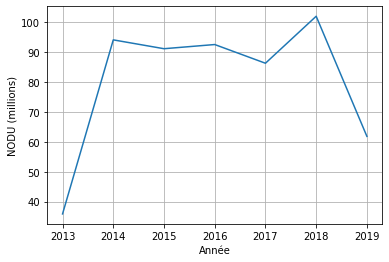

In [8]:
plt.plot(annees,NODU)
plt.xlabel('Année')
plt.ylabel('NODU (millions)')
plt.grid()

L'allure est bonne, mais quantitativement on n'y est pas encore...